In [1]:
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt

from qiskit_ode.dispatch import Array
from qiskit_ode.signals.new_signals import Signal, Constant, PiecewiseConstant, SignalSum

## Vectorized evaluation

Things are now written to explicitly enable vectorized evaluation.

In [2]:
sig1 = Signal(lambda t: t, carrier_freq=0.1)

In [3]:
sig1(np.array([2., 3.]))

array([ 0.61803399, -0.92705098])

If the user specifies a function which is not vectorized, they can specify that it needs to be.

In [4]:
def nonvectorized_func(t):
    if t < 1.:
        return t
    else:
        return 50.

sig2 = Signal(nonvectorized_func, carrier_freq=1.0, vectorize_envelope=True)

In [5]:
sig2(np.array([0.1, 2., -1., 3.]))

array([ 0.0809017, 50.       , -1.       , 50.       ])

Currently it is necessary to pass such a list as an array.

## Plotting

Plot the signal, the envelope, and the complex value.

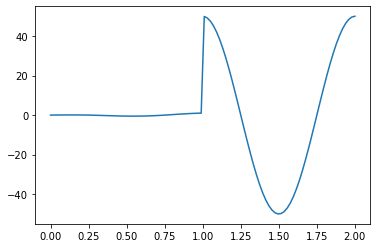

In [6]:
sig2.plot(0, 2, 100)

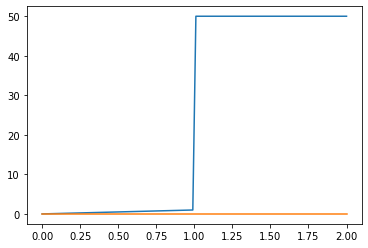

In [7]:
sig2.plot_envelope(0, 2, 100)

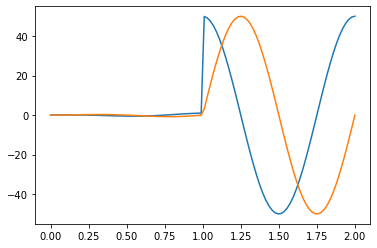

In [8]:
sig2.plot_complex_value(0, 2, 100)

## string rep

In [9]:
str(sig2)

'Signal(carrier_freq=1.0, phase=0.0)'

In [10]:
sig2.name = 'new_name'
str(sig2)

'new_name'

## SignalSum

still need to define summation but want to check vectorized evaluation is working

In [11]:
sig1 = Signal(lambda t: t + t**2 * 1j, carrier_freq=1.)
sig2 = Signal(lambda t: -t, carrier_freq=2.)

In [12]:
sig_sum = SignalSum(sig1, sig2)
str(sig_sum)

'Signal(carrier_freq=1.0, phase=0.0) + Signal(carrier_freq=2.0, phase=0.0)'

In [13]:
t = 0.2
print(sig_sum(t))
print(sig1(t) + sig2(t))

0.18556453709817283
0.18556453709817283


In [14]:
t = np.array([1.1, 0.2])
print(sig_sum(t))
print(sig1(t) + sig2(t))

[-0.16122016  0.18556454]
[-0.16122016  0.18556454]


In [15]:
t = np.array([[1.1, 0.2], [4.6, 4.7]])
print(sig_sum(t))
print(sig1(t) + sig2(t))

[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]
[[-0.16122016  0.18556454]
 [ 7.29457959 23.35883844]]


## simplification

In [16]:
sig_sum = SignalSum(Signal(1., carrier_freq=2.), Signal(2., carrier_freq=-2.))
sig_sum.simplify()

In [17]:
len(sig_sum)

1

In [18]:
sig_sum(0.1)

0.9270509831248424

## merging

In [19]:
sig1 = Signal(1., carrier_freq=2.)
sig2 = Signal(2., carrier_freq=3.)
sig_sum = SignalSum(sig1, sig2)

In [20]:
sig_sum(1.2)

-2.4270509831248432

In [21]:
sig1(1.2) + sig2(1.2)

-2.4270509831248432

In [22]:
# returns a single signal with frequencies averaged
sig_merged = sig_sum.merge()

In [23]:
sig_merged(1.2)

-2.427050983124843

In [24]:
sig_merged.carrier_freq

Array(2.5, backend='numpy')

## Constant

In [25]:
const = Constant(3.)

In [26]:
const.envelope(np.array([1., 1.]))

Array([3.+0.j, 3.+0.j], backend='numpy')

In [27]:
const(np.array([1., 1.]))

Array([3., 3.], backend='numpy')

## PiecewiseConstant

In [28]:
sig = PiecewiseConstant(dt=1., samples=np.array([1., 2., 3.]), carrier_freq=0.5)

In [29]:
sig(np.array([2.1, 1.1]))

Array([ 2.85316955, -1.90211303], backend='numpy')

In [30]:
not isinstance(sig, SignalSum)

True

In [31]:
test = Array(1.)

In [32]:
test.ndim

0

## Signal addition

In [33]:
sig1 = Signal(1., carrier_freq=2.)
sig2 = Signal(2., carrier_freq=3.)
sig3 = PiecewiseConstant(dt=0.5, samples=np.array([1., 2., 3.]))
sig_sum = sig1 + sig2

In [34]:
sig_sum2 = 2. + sig1
sig_sum3 = sig1 + 2.
sig_sum4 = sig3 + sig1

In [35]:
str(sig_sum2)

'Signal(carrier_freq=2.0, phase=0.0) + Constant(2.0)'

In [36]:
str(sig_sum3)

'Signal(carrier_freq=2.0, phase=0.0) + Constant(2.0)'

In [37]:
str(sig_sum4)

'PiecewiseConstant(dt=0.5, carrier_freq=0.0, phase=0.0) + Signal(carrier_freq=2.0, phase=0.0)'

In [38]:
sig3.name = 5.

## Multiplication

In [39]:
sig_prod = sig1 * sig2

In [40]:
print(sig1.carrier_freq)
print(sig2.carrier_freq)

2.0
3.0


In [41]:
sig_prod.carrier_freq

Array([ 5., -1.], backend='numpy')

In [42]:
sig_prod(1.1) - (sig1(1.1) * sig2(1.1))

-1.609823385706477e-15

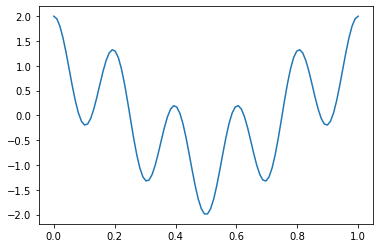

In [43]:
sig_prod.plot(0., 1., 100)

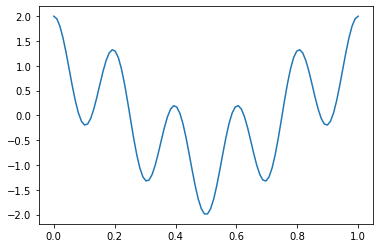

In [44]:
t_vals = np.linspace(0., 1., 100)
y_vals = sig1(t_vals) * sig2(t_vals)
plt.plot(t_vals, y_vals)

## special multiplication rules

Constants have their internal values multiplied

In [45]:
const_prod = Constant(3.) * Constant(2.)
str(const_prod)

'Constant(6.0)'

PiecewiseConstants with compatible parameters (start time, dt, and number of samples) are implemented via array multiplication. (We can extend these rules to pad signals and what not.)

In [49]:
pwc_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
            PiecewiseConstant(dt=0.1, samples=np.array([4.,5.,6.]), carrier_freq=2.))
str(pwc_prod)

'PiecewiseConstant(dt=0.1, carrier_freq=3.0, phase=0.0) + PiecewiseConstant(dt=0.1, carrier_freq=-1.0, phase=0.0)'

If one of the piecewise constants has zero frequency, then it returns only a single piecewise constant.

In [52]:
pwc_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.])) *
            PiecewiseConstant(dt=0.1, samples=np.array([4.,5.,6.]), carrier_freq=2.))
print(str(pwc_prod))
pwc_prod(0.02) - (1. * 4. * np.cos(2 * np.pi * 2. * 0.02))

PiecewiseConstant(dt=0.1, carrier_freq=2.0, phase=0.0)


0.0

For pairs for which special handling doesn't apply generic Signals are returned.

In [55]:
general_prod = (PiecewiseConstant(dt=0.1, samples=np.array([1.,2.,3.]), carrier_freq=1.) *
               Signal(envelope=lambda t: t, carrier_freq=2.))
print(str(general_prod))
general_prod(0.02) - (np.cos(2 * np.pi * 0.02) * 0.02 * np.cos(2 * np.pi * 2. * 0.02))

Signal(carrier_freq=3.0, phase=0.0) + Signal(carrier_freq=-1.0, phase=0.0)


0.0